In [1]:
import os
import polars as pl
import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
from scipy.stats import ttest_ind, ttest_1samp

from sklearn.metrics import roc_auc_score
from sklearn import metrics
import matplotlib.pyplot as plt
from scipy import interpolate
import joblib

In [2]:
def get_detection_method_string(detection_method):
    # detection method params
    minimum_duration = 100
    dispersion_threshold = 1.0
    velocity_threshold = 20.0
    
    if detection_method == 'ivt':
        detection_params = {'minimum_duration': minimum_duration,
                            'velocity_threshold': velocity_threshold,
                        }
    elif detection_method == 'idt':
        detection_params = {'minimum_duration': minimum_duration,
                            'dispersion_threshold': dispersion_threshold,
                        }
    elif detection_method == 'microsaccades':
        detection_params = {'minimum_duration': minimum_duration,
                        }
    
    detection_param_string = detection_method + '_'
    for key in detection_params:
        detection_param_string += str(key) + '_' + str(detection_params[key]) + '_'
    detection_param_string = detection_param_string[0:len(detection_param_string)-1]
    return detection_param_string

def avg_tpr_fpr_curve(fprs, tprs, label, plot_random=False,
                title = None, plot_statistics = False,
                loc = 'best', plot_legend = True,
                plot_points = 10000, ncol=1,
                bbox_to_anchor=None,
                starting_point = None,
                fontsize = 14, xscale = None,
                decimals=3,
                color = None):

    """
    Plot average roc curve from multiple fpr and tpr arrays of multiple cv-folds

    :param fprs: list of fpr arrays for the different folds
    :param tprs: list of tpr arrays for the different folds
    :label: name for the legend
    :plot_random: indicator, indicating if the random guessing curve should be plotted
    :title: title of plot; no title if 'None'
    :plot_statistics: if True, statistics for all the folds are plotted
    :loc: location of legend
    :plot_legend: if True legend is plotted
    :plot_points: number of points to plot
    :ncol: number of columns for legend
    :bbox_to_anchor: bounding box for legend outside of plot
    :starting_point: indicates the starting point of drawing the curves
    :fontsize: fontsize
    :xscale: scale for x-axis
    """
    if xscale is not None:
        plt.xscale(xscale)

    tprs_list = []
    aucs = []
    for i in range(0, len(fprs)):
        fpr = fprs[i]
        tpr = tprs[i]

        tprs_list.append(interpolate.interp1d(fpr, tpr))
        aucs.append(metrics.auc(fprs[i], tprs[i]))
    aucs = np.array(aucs)
    x = np.linspace(0, 1, plot_points)
    if starting_point is not None:
        x = x[x > starting_point]    
        
    if plot_random:
        plt.plot(x,x, color='grey', linestyle='dashed',
                 label='Random guessing')

    # plot average and std error of those roc curves:        
    ys = np.vstack([f(x) for f in tprs_list])
    ys_mean = ys.mean(axis=0)
    ys_std = ys.std(axis=0) / np.sqrt(len(fprs))
    cur_label = label
    if plot_statistics:
        cur_label += ' (AUC=' + str(np.round(np.mean(aucs), decimals)) + ' $\\pm$ ' +\
                    str(np.round(np.std(aucs) / np.sqrt(len(aucs)), decimals)) + ')'

    if color is None:
        p = plt.plot(x, ys_mean, label=cur_label)
        print(p[0].get_color())
        plt.fill_between(x, ys_mean - ys_std, ys_mean + ys_std, alpha=0.2)
    else:
        plt.plot(x, ys_mean, label=cur_label, color=color)
        plt.fill_between(x, ys_mean - ys_std, ys_mean + ys_std, alpha=0.2, color=color)
    if plot_legend:
        if bbox_to_anchor is None:
            plt.legend(loc=loc, ncol=ncol,fontsize=fontsize)
        else:
            plt.legend(loc=loc, ncol=ncol, bbox_to_anchor = bbox_to_anchor,fontsize=fontsize)
    plt.xlabel('False Positive Rate', fontsize=fontsize)
    plt.ylabel('True Positive Rate', fontsize=fontsize)
    plt.xticks(fontsize = fontsize)
    plt.yticks(fontsize = fontsize)

    plt.grid('on')
    if title is not None:
        plt.title(title)
        
    return aucs

In [3]:
result_dir = 'results/'
plot_dir = 'plots/'
data_dir = 'data/'
window_size = 10000
window_sizes = [10000, 30000, 60000, 120000]
stride = window_size
detection_method = 'idt'
detection_methods = ['idt','ivt', 'microsaccades']
bac_threshold = 0.0
bac_thresholds = [0.0, 0.01, 0.02, 0.03]
data_source = 'pupilcore'
feature_sets = ['all', 'pupil', 'onlyvel', 'onlypupil']
feature_set_names = ['All features', 'W/O pupil features',  'Only eye movements', 'Only pupil features']
feature_colors = ['#1f77b4', '#ff7f0e', '#d62728', '#9467bd']
group_variables = [ 'trial-time', 'trial', 'subject',]# 'random',]
group_variable_names = ['closed-population (time-split)', 'closed-population (trial-split)', 'open-population',]# 'random',]
decimals = 3
use_metric = 'aucs_instance'#'aucs_subject' # 'aucs_instance'
if use_metric == 'aucs_instance':
    fpr = 'fpr_instance'
    tpr = 'tpr_instance'
elif use_metric == 'aucs_subject':
    fpr = 'fpr_subject'
    tpr = 'tpr_subject'

In [4]:
detection_method = 'idt'
data_source = 'eyelink'
window_size = 60000
stride = window_size
bac_threshold = 0.0

closed-population (time-split)
All features & 0.872 $\pm$ 0.015*\\
W/O pupil features & 0.873 $\pm$ 0.013*\\
Only eye movements & 0.87 $\pm$ 0.014*\\
Only pupil features & 0.66 $\pm$ 0.018*\\


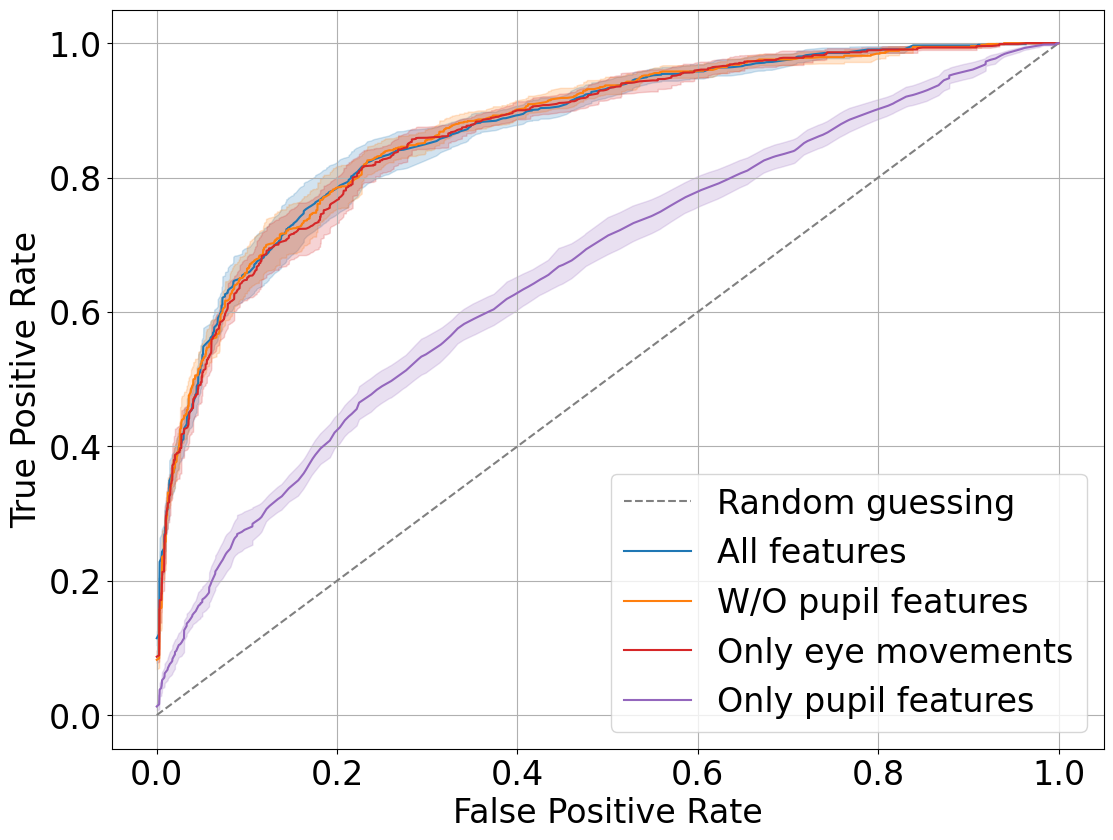

closed-population (trial-split)
All features & 0.645 $\pm$ 0.024\\
W/O pupil features & 0.641 $\pm$ 0.017\\
Only eye movements & 0.644 $\pm$ 0.022\\
Only pupil features & 0.55 $\pm$ 0.007\\


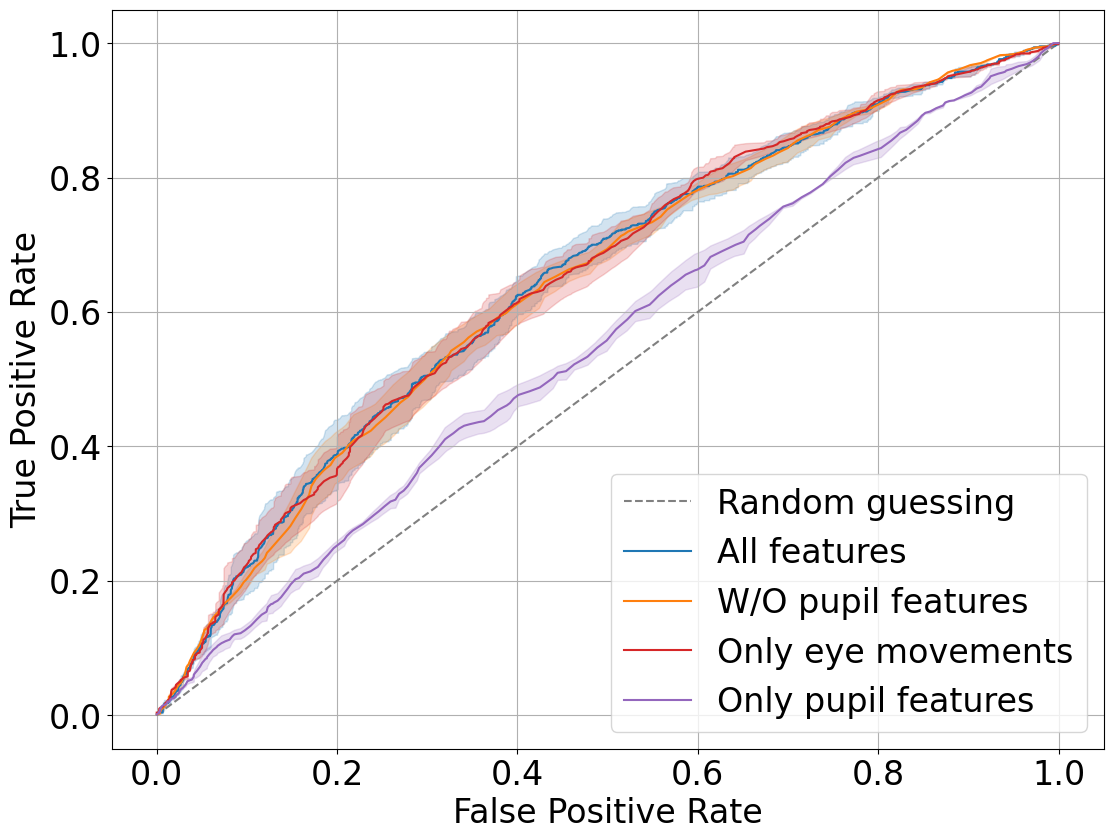

open-population
All features & 0.527 $\pm$ 0.006*\\
W/O pupil features & 0.537 $\pm$ 0.007*\\
Only eye movements & 0.536 $\pm$ 0.011*\\
Only pupil features & 0.525 $\pm$ 0.018\\


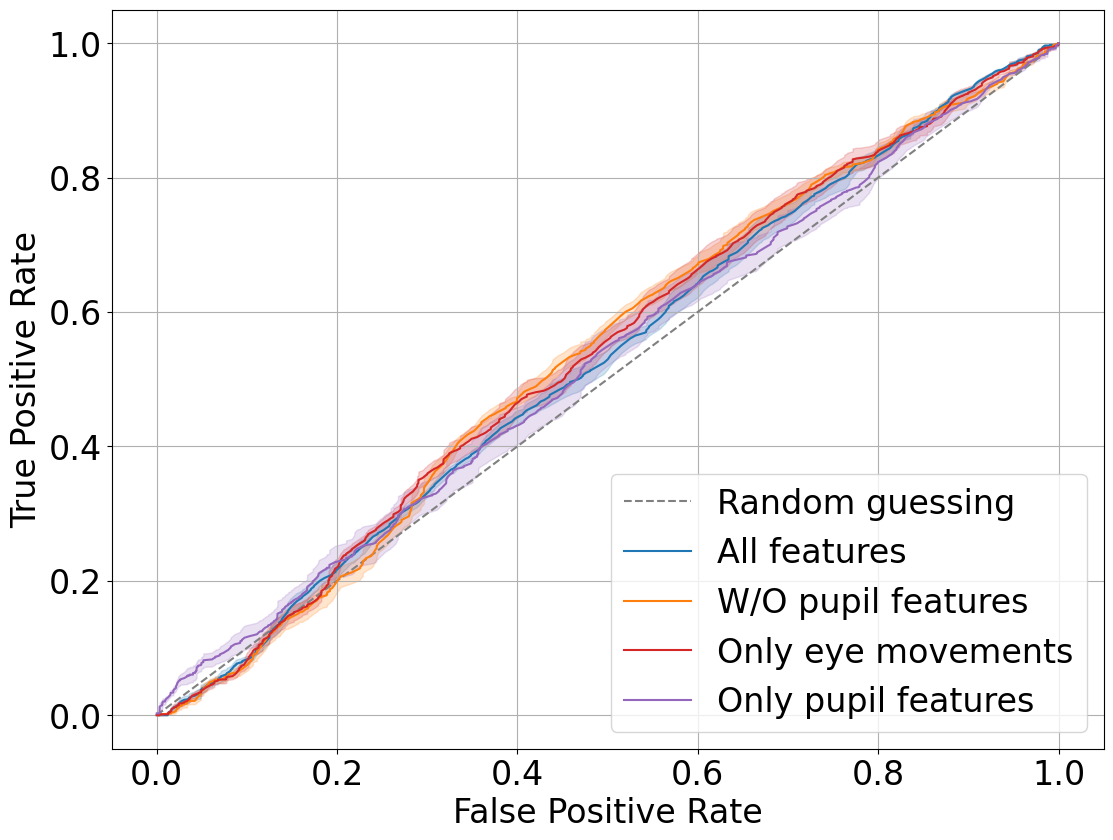

In [5]:
scale_factor = 2
for i in range(len(group_variables)):
    group_variable = group_variables[i]
    group_variable_name = group_variable_names[i]
    print(group_variable_name)
    plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
    for j in range(len(feature_sets)):
        cur_feature = feature_sets[j]
        cur_feature_name = feature_set_names[j]
        cur_feature_color = feature_colors[j]
        detection_string = get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf'
        try:
            joblib_path = cur_load_path + '.joblib'
            csv_path = cur_load_path + '.csv'
            cur_data = joblib.load(joblib_path)
            cur_df = pl.read_csv(csv_path)
        except:
            continue        
        if j == 0:
            plot_random = True
        else:
            plot_random = False
        cur_aucs = np.array(cur_df[use_metric])
        better_random_pvalue = ttest_1samp(a=cur_aucs,popmean=0.5,alternative = 'greater').pvalue
        if better_random_pvalue < 0.05:
            cur_p_value_add_str = '*'
        else:
            cur_p_value_add_str = ''
        table_str = cur_feature_name + ' & ' + str(np.round(np.mean(cur_aucs), decimals)) + ' $\\pm$ ' +\
                        str(np.round(np.std(cur_aucs) / np.sqrt(len(cur_aucs)), decimals)) + cur_p_value_add_str + '\\\\'
        print(table_str)
        avg_tpr_fpr_curve(cur_data[fpr], cur_data[tpr], cur_feature_name, plot_random=plot_random,
                          plot_statistics=False, fontsize = 24, loc='lower right', color=cur_feature_color)
    plt.savefig(plot_dir + group_variable_name + '_' + str(data_source) + '_auc.pdf', dpi=300)
    plt.show()

### Plots for BAC levels

In [6]:
scale_factor = 2
bac_threshold = 0.0
for i in range(len(group_variables)):
    group_variable = group_variables[i]
    group_variable_name = group_variable_names[i]
    print(group_variable_name)
    plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
    for j in range(len(feature_sets)):
        cur_feature = feature_sets[j]
        cur_feature_name = feature_set_names[j]
        cur_feature_color = feature_colors[j]
        detection_string = get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf' + '_save_scores'
        joblib_path = cur_load_path + '.joblib'
        if not os.path.exists(joblib_path):
            print('skip: ' + str(joblib_path))
            continue
        cur_data = joblib.load(joblib_path)

        bac_levels = np.arange(0,0.04,0.005)
        num_folds = len(cur_data['fold_dicts'])
        auc_matrix = np.zeros([len(bac_levels), num_folds])
        
        for b_i in range(len(bac_levels)):
            bac_level = bac_levels[b_i]
            for fold_i in range(num_folds):
                cur_fold_data = cur_data['fold_dicts'][fold_i]
                neg_ids = np.where(cur_fold_data['y_test_bac'] == 0)[0]
                pos_ids = np.where(cur_fold_data['y_test_bac'] > bac_level)[0]
                use_ids = np.concatenate([neg_ids, pos_ids])
                fpr, tpr, _ = metrics.roc_curve(cur_fold_data['y_test'][use_ids], cur_fold_data['predictions'][use_ids], pos_label=1)
                auc = metrics.auc(fpr, tpr)
                auc_matrix[b_i, fold_i] = auc
        plt.errorbar(np.arange(len(bac_levels)), np.mean(auc_matrix, axis=1), np.std(auc_matrix, axis=1),
                    label=cur_feature_name, color=cur_feature_color)
    plt.plot(np.arange(len(bac_levels)),[0.5 for _ in np.arange(len(bac_levels))], color='grey', linestyle='dashed',
                 label='Random guessing')
    plt.xlabel('BAC threshold')
    plt.ylabel('ROCAUC')
    plt.xticks(np.arange(len(bac_levels)),bac_levels)
    plt.legend()
    plt.ylim([0.45,0.75])
    plt.savefig(plot_dir + group_variable_name + '_' + str(data_source) + '_bac_levels.pdf', dpi=300)
    plt.show()

closed-population (time-split)
skip: results//idt_minimum_duration_100_dispersion_threshold_1.0_eyelink_window_60000_stride_60000_bac_0.0_splitting_trial-time_feature_all_rf_save_scores.joblib
skip: results//idt_minimum_duration_100_dispersion_threshold_1.0_eyelink_window_60000_stride_60000_bac_0.0_splitting_trial-time_feature_pupil_rf_save_scores.joblib
skip: results//idt_minimum_duration_100_dispersion_threshold_1.0_eyelink_window_60000_stride_60000_bac_0.0_splitting_trial-time_feature_onlyvel_rf_save_scores.joblib
skip: results//idt_minimum_duration_100_dispersion_threshold_1.0_eyelink_window_60000_stride_60000_bac_0.0_splitting_trial-time_feature_onlypupil_rf_save_scores.joblib


NameError: name 'bac_levels' is not defined

<Figure size 1280x960 with 0 Axes>

### Boxplot for subject specific ROCAUC's

In [ ]:
scale_factor = 2
bac_threshold = 0.0
for i in range(len(group_variables)):
    group_variable = group_variables[i]
    group_variable_name = group_variable_names[i]
    print(group_variable_name)
    plt.figure(figsize = [6.4*scale_factor, 4.8*scale_factor])
    auc_values = []
    feature_values = []
    for j in range(len(feature_sets)):
        cur_feature = feature_sets[j]
        cur_feature_name = feature_set_names[j]
        cur_feature_color = feature_colors[j]
        detection_string = get_detection_method_string(detection_method)
        cur_load_path = result_dir + '/' + detection_string + '_' + data_source + '_' +\
                        'window_' + str(window_size) + '_' +\
                        'stride_' + str(stride) + '_' +\
                        'bac_' + str(bac_threshold) + '_' +\
                        'splitting_' + str(group_variable) + '_' +\
                        'feature_' + str(cur_feature) + '_rf' + '_save_scores'
        joblib_path = cur_load_path + '.joblib'
        if not os.path.exists(joblib_path):
            print('skip: ' + str(joblib_path))
            continue
        cur_data = joblib.load(joblib_path)
        num_folds = len(cur_data['fold_dicts'])
        
        subject_aucs = []
        for fold_i in range(num_folds):
            cur_fold_data = cur_data['fold_dicts'][fold_i]
            fold_subjects = cur_fold_data['subjects_test']
            unique_subjects = list(np.unique(fold_subjects))
            for s_i in range(len(unique_subjects)):
                c_subject = unique_subjects[s_i]
                c_ids = np.where(np.array(fold_subjects) == c_subject)[0]
                if len(np.unique(cur_fold_data['y_test'][c_ids])) == 1:
                    continue
                fpr, tpr, _ = metrics.roc_curve(cur_fold_data['y_test'][c_ids], cur_fold_data['predictions'][c_ids], pos_label=1)
                auc = np.float32(metrics.auc(fpr, tpr))
                subject_aucs.append(auc)
                auc_values.append(auc)
                feature_values.append(cur_feature_name)
    box_data = pl.DataFrame({'ROCAUC': auc_values,
                             'Feature set': feature_values})
    #sns.boxplot(box_data,x='Feature set', y = 'ROCAUC', palette=my_pal)
    sns.boxplot(hue=box_data['Feature set'], y=box_data['ROCAUC'], palette=my_pal, gap=0.1)
    plt.savefig(plot_dir + group_variable_name + '_' + str(data_source) + '_box_subject_aucs.pdf', dpi=300)
    plt.show()